In [1]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from datetime import datetime
import os

os.environ['http_proxy'] = 'http://192.41.170.23:3128'
os.environ['https_proxy'] = 'http://192.41.170.23:3128'

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

In [2]:
data = pd.read_csv('dataset_eurousd.csv', delimiter = '\t')
data.tail()

,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<TICKVOL>,<VOL>,<SPREAD>
61997,2022.04.08,14:00:00,1.08861,1.08881,1.08592,1.08638,3897,0,0
61998,2022.04.08,15:00:00,1.08637,1.08660,1.08504,1.08531,4443,0,0
61999,2022.04.08,16:00:00,1.08531,1.08581,1.08364,1.08399,6250,0,0
62000,2022.04.08,17:00:00,1.08399,1.08804,1.08388,1.08727,6825,0,0
62001,2022.04.08,18:00:00,1.08725,1.08815,1.08716,1.08757,2771,0,0


In [3]:
data.columns =['DATE', 'TIME', 'OPEN', 'HIGH', 'LOW', 'CLOSE', 'TICKVOL',
       'VOL', 'SPREAD']
data.columns

Index(['DATE', 'TIME', 'OPEN', 'HIGH', 'LOW', 'CLOSE', 'TICKVOL', 'VOL',
       'SPREAD'],
      dtype='object')

In [4]:
# df['DATETIME'] = pd.to_datetime(df['DATE'] + ' ' + df['TIME'], format='%Y.%m.%d %H:%M:%S')
# df = df.drop(['DATE', 'TIME'], axis = 1)

In [5]:
# df = df.set_index(['DATETIME'])
# df.index = pd.to_datetime(df.index)
# if not df.index.is_monotonic:
#     df = df.sort_index()

In [6]:
# def generate_time_lags(df, n_lags):
#     df_n = df.copy()
#     for n in range(1, n_lags + 1):
#         df_n[f"lag{n}"] = df_n["CLOSE"].shift(n)
#     df_n = df_n.iloc[n_lags:]
#     return df_n
    
# input_dim = 100

# df_generated = generate_time_lags(df, input_dim)
# df_generated

# df['CLOSE'].shift(2)

In [7]:
# df = df.rename(columns={'CLOSE': 'value'})
# plot_dataset(df, title='EURUSD')
# plt.scatter(df.index, df.value)

In [8]:
date_filter = data['DATE'] == '2021.01.04'
time_filter = data['TIME'] == '00:00:00'
idx_bool = date_filter * time_filter
idx = data[idx_bool].index.tolist()[0]
# idx_bool.sum()

In [9]:
train = data.iloc[:idx]
test = data.iloc[idx:]

In [10]:
test[:1]

,DATE,TIME,OPEN,HIGH,LOW,CLOSE,TICKVOL,VOL,SPREAD
54097,2021.01.04,00:00:00,1.22395,1.22398,1.2228,1.22341,521,0,0


In [11]:
train.shape

(54097, 9)

In [12]:
test.shape

(7905, 9)

In [13]:
len(train) /(len(train) + len(test))

0.8725041127705558

In [14]:
n_steps = 720
pred_len = 720

def split_sequence(sequence, n_steps, pred_len):
    x, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence)-1:
            break
        # print(sequence)

        seq_y = sequence.iloc[end_ix:end_ix + pred_len, 5]
        seq_y = seq_y.values
        # print(seq_y)
        seq_x = sequence[i:end_ix].drop(["DATE","TIME","SPREAD"], axis = 1)
        
        # print(seq_x.shape)
        if len(seq_x) == n_steps and len(seq_y) == pred_len:
            x.append(seq_x)
            y.append(seq_y)
    return np.array(x), np.array(y)

In [15]:
x_data, y_data = split_sequence(train, n_steps, pred_len)
x_test, y_test = split_sequence(test, n_steps, pred_len)

# data2 = timeseries_dataset[0]
# data2[0].shape

In [16]:
print(x_data.shape)
print(y_data.shape)
print(x_test.shape)
print(y_test.shape)

(52658, 720, 6)
(52658, 720)
(6466, 720, 6)
(6466, 720)


In [17]:
class Custom_dataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        
        return self.data[idx], self.labels[idx]

In [18]:
batch_size = 128
train_ratio = 0.9
train_size = round(len(x_data) * train_ratio)

x_train = x_data[:train_size]
y_train = y_data[:train_size]
x_val = x_data[train_size:]
y_val = y_data[train_size:]

train_dataset = Custom_dataset(x_train, y_train)
val_dataset = Custom_dataset(x_val, y_val)
test_dataset = Custom_dataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = False, num_workers = 2, drop_last= True)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = False, num_workers = 2, drop_last = True)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False, num_workers = 2, drop_last = True)

In [19]:
print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

370
41
50


In [20]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(RNNModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # RNN layers
        self.rnn = nn.RNN(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().to(device)

        # Forward propagation by passing in the input and hidden state into the model
        out, h0 = self.rnn(x, h0.detach())

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)
        return out

In [21]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(LSTMModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # LSTM layers
        self.lstm = nn.LSTM(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob, bidirectional = True
        )

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim * 2, x.size(0), self.hidden_dim).requires_grad_().to(device)

        # Initializing cell state for first input with zeros
        c0 = torch.zeros(self.layer_dim * 2, x.size(0), self.hidden_dim).requires_grad_().to(device)

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        # Forward propagation by passing in the input, hidden state, and cell state into the model
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)

        return out

In [22]:
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(GRUModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.layer_dim = layer_dim
        self.hidden_dim = hidden_dim

        # GRU layers
        self.gru = nn.GRU(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().to(device)

        # Forward propagation by passing in the input and hidden state into the model
        out, _ = self.gru(x, h0.detach())

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)

        return out

In [23]:
def get_model(model, model_params):
    models = {
        "rnn": RNNModel,
        "lstm": LSTMModel,
        "gru": GRUModel,
    }
    return models.get(model.lower())(**model_params)


In [24]:
class Optimization:
    def __init__(self, model, loss_fn, optimizer):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.train_losses = []
        self.val_losses = []
    
    def train_step(self, x, y):
        # Sets model to train mode
        self.model = self.model.to(device)
        self.model.train()
        x = x.to(device)
        y = y.to(device)
        
        # Makes predictions
        yhat = self.model(x.float())

        # Computes loss
        loss = self.loss_fn(y.float(), yhat)

        # Computes gradients
        loss.backward()

        # Updates parameters and zeroes gradients
        self.optimizer.step()
        self.optimizer.zero_grad()

        # Returns the loss
        return loss.item()
    
    def train(self, train_loader, val_loader, batch_size=256, n_epochs=10, n_features=6):
        model_path = f'models/LSTM_{datetime.now().strftime("%Y-%m-%d %H:%M:%S")}'

        for epoch in range(1, n_epochs + 1):
            batch_losses = []
            for x_batch, y_batch in train_loader:
                # print(x_batch.size())
                x_batch = x_batch.view([batch_size, -1, n_features]).to(device)
                y_batch = y_batch.to(device)
                loss = self.train_step(x_batch, y_batch)
                batch_losses.append(loss)
            training_loss = np.mean(batch_losses)
            self.train_losses.append(training_loss)

            with torch.no_grad():
                batch_val_losses = []
                for x_val, y_val in val_loader:
                    x_val = x_val.view([batch_size, -1, n_features]).to(device)
                    y_val = y_val.to(device)
                    self.model.eval()
                    yhat = self.model(x_val.float())
                    val_loss = self.loss_fn(y_val.float(), yhat).item()
                    batch_val_losses.append(val_loss)
                validation_loss = np.mean(batch_val_losses)
                self.val_losses.append(validation_loss)

            if (epoch <= 50) | (epoch % 50 == 0):
                print(
                    f"[{epoch}/{n_epochs}] Training loss: {training_loss:.6f}\t Validation loss: {validation_loss:.6f}"
                )
        torch.save(self.model.state_dict(), model_path)
    
    def evaluate(self, test_loader, batch_size=256, n_features=6):
        with torch.no_grad():
            predictions = []
            values = []
            for x_test, y_test in test_loader:
                x_test = x_test.view([batch_size, -1, n_features]).to(device)
                y_test = y_test.to(device)
                self.model.eval()
                yhat = self.model(x_test.float())
                predictions.append(yhat.cpu().detach().numpy())
                values.append(y_test.cpu().detach().numpy())

        return predictions, values
    
    def plot_losses(self):
        plt.plot(self.train_losses, label="Training loss")
        plt.plot(self.val_losses, label="Validation loss")
        plt.legend()
        plt.title("Losses")
        plt.show()
        plt.close()

In [25]:
def format_predictions(predictions, values):
    vals = np.concatenate(values, axis=0).ravel()
    preds = np.concatenate(predictions, axis=0).ravel()
    df_result = pd.DataFrame(data={"value": vals, "prediction": preds})
    # df_result = df_result.sort_index()
    # df_result = inverse_transform(scaler, df_result, [["value", "prediction"]])
    return df_result

[1/10] Training loss: 0.965781	 Validation loss: 0.266880
[2/10] Training loss: 0.152344	 Validation loss: 0.021330
[3/10] Training loss: 0.023633	 Validation loss: 0.004164
[4/10] Training loss: 0.011527	 Validation loss: 0.002968
[5/10] Training loss: 0.009664	 Validation loss: 0.002534
[6/10] Training loss: 0.008845	 Validation loss: 0.002220
[7/10] Training loss: 0.008200	 Validation loss: 0.002027
[8/10] Training loss: 0.007651	 Validation loss: 0.001914
[9/10] Training loss: 0.007126	 Validation loss: 0.001849
[10/10] Training loss: 0.006740	 Validation loss: 0.001840


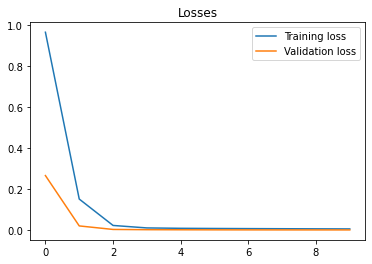

In [26]:
import torch.optim as optim

input_dim = 6
hidden_dim = 256
output_dim = 720
layer_dim = 2
dropout = 0.3
n_epochs = 10
learning_rate = 1e-5
weight_decay = 1e-5

model_params = {'input_dim': input_dim,
                'hidden_dim' : hidden_dim,
                'layer_dim' : layer_dim,
                'output_dim' : output_dim,
                'dropout_prob' : dropout}

model = get_model('rnn', model_params)

loss_fn = nn.MSELoss(reduction="mean")
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

opt = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer)
opt.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
opt.plot_losses()

predictions, values = opt.evaluate(test_loader, batch_size=batch_size, n_features=input_dim)

In [27]:
df_result = format_predictions(predictions, values)

In [28]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def calculate_metrics(df):
    return {'mae' : mean_absolute_error(df.value, df.prediction),
            'rmse' : mean_squared_error(df.value, df.prediction) ** 0.5,
            'r2' : r2_score(df.value, df.prediction)}

result_metrics = calculate_metrics(df_result)
print(result_metrics)

{'mae': 0.037043340570964284, 'rmse': 0.04480936528977203, 'r2': -0.9215659193963357}


[1/25] Training loss: 1.005069	 Validation loss: 0.137130
[2/25] Training loss: 0.060116	 Validation loss: 0.003188
[3/25] Training loss: 0.009333	 Validation loss: 0.002285
[4/25] Training loss: 0.007297	 Validation loss: 0.001998
[5/25] Training loss: 0.006297	 Validation loss: 0.001901
[6/25] Training loss: 0.005489	 Validation loss: 0.001895
[7/25] Training loss: 0.004879	 Validation loss: 0.001940
[8/25] Training loss: 0.004406	 Validation loss: 0.002002
[9/25] Training loss: 0.004004	 Validation loss: 0.002061
[10/25] Training loss: 0.003734	 Validation loss: 0.002117
[11/25] Training loss: 0.003498	 Validation loss: 0.002143
[12/25] Training loss: 0.003311	 Validation loss: 0.002131
[13/25] Training loss: 0.003148	 Validation loss: 0.002144
[14/25] Training loss: 0.003030	 Validation loss: 0.002105
[15/25] Training loss: 0.002969	 Validation loss: 0.002118
[16/25] Training loss: 0.002915	 Validation loss: 0.002119
[17/25] Training loss: 0.002854	 Validation loss: 0.002131
[18/25

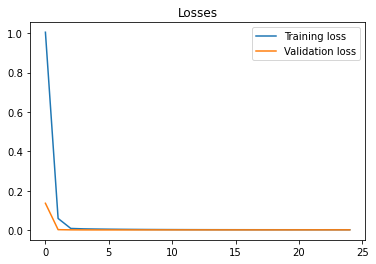

In [29]:
import torch.optim as optim

input_dim = 6
hidden_dim = 256
output_dim = 720
layer_dim = 2
dropout = 0.3
n_epochs = 25
learning_rate = 1e-5
weight_decay = 1e-5

model_params = {'input_dim': input_dim,
                'hidden_dim' : hidden_dim,
                'layer_dim' : layer_dim,
                'output_dim' : output_dim,
                'dropout_prob' : dropout}

model = get_model('lstm', model_params)

loss_fn = nn.MSELoss(reduction="mean")
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

opt = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer)
opt.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
opt.plot_losses()

predictions, values = opt.evaluate(test_loader, batch_size=batch_size, n_features=input_dim)

In [30]:
df_result = format_predictions(predictions, values)

In [31]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def calculate_metrics(df):
    return {'mae' : mean_absolute_error(df.value, df.prediction),
            'rmse' : mean_squared_error(df.value, df.prediction) ** 0.5,
            'r2' : r2_score(df.value, df.prediction)}

result_metrics = calculate_metrics(df_result)
print(result_metrics)

{'mae': 0.05138668780734423, 'rmse': 0.05867561364740019, 'r2': -2.2948297861713574}


[1/25] Training loss: 1.080697	 Validation loss: 0.367319
[2/25] Training loss: 0.190057	 Validation loss: 0.022749
[3/25] Training loss: 0.020491	 Validation loss: 0.003811
[4/25] Training loss: 0.008598	 Validation loss: 0.002880
[5/25] Training loss: 0.007427	 Validation loss: 0.002561
[6/25] Training loss: 0.006743	 Validation loss: 0.002231
[7/25] Training loss: 0.006294	 Validation loss: 0.002035
[8/25] Training loss: 0.005894	 Validation loss: 0.001919
[9/25] Training loss: 0.005338	 Validation loss: 0.001837
[10/25] Training loss: 0.004884	 Validation loss: 0.001786
[11/25] Training loss: 0.004513	 Validation loss: 0.001753
[12/25] Training loss: 0.004119	 Validation loss: 0.001739
[13/25] Training loss: 0.003856	 Validation loss: 0.001742
[14/25] Training loss: 0.003593	 Validation loss: 0.001756
[15/25] Training loss: 0.003326	 Validation loss: 0.001771
[16/25] Training loss: 0.003219	 Validation loss: 0.001791
[17/25] Training loss: 0.003010	 Validation loss: 0.001805
[18/25

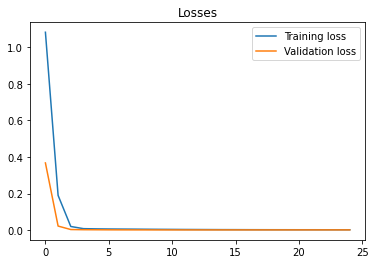

In [32]:
import torch.optim as optim

input_dim = 6
hidden_dim = 256
output_dim = 720
layer_dim = 2
dropout = 0.3
n_epochs = 25
learning_rate = 1e-5
weight_decay = 1e-5

model_params = {'input_dim': input_dim,
                'hidden_dim' : hidden_dim,
                'layer_dim' : layer_dim,
                'output_dim' : output_dim,
                'dropout_prob' : dropout}

model = get_model('gru', model_params)

loss_fn = nn.MSELoss(reduction="mean")
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

opt = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer)
opt.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
opt.plot_losses()

predictions, values = opt.evaluate(test_loader, batch_size=batch_size, n_features=input_dim)

In [33]:
df_result = format_predictions(predictions, values)

In [34]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def calculate_metrics(df):
    return {'mae' : mean_absolute_error(df.value, df.prediction),
            'rmse' : mean_squared_error(df.value, df.prediction) ** 0.5,
            'r2' : r2_score(df.value, df.prediction)}

result_metrics = calculate_metrics(df_result)
print(result_metrics)

{'mae': 0.044271884901612386, 'rmse': 0.055343353697983974, 'r2': -1.931221577096124}


$
\textit{QL}(\textit{y},\hat{y},\textit{q}) = \textit{q}(\textit{y}-\hat{y})_{+} + (1-\textit{q})(\hat{y}-\textit{y})_{+}
$

$
\textit{L}(\omega,\textbf{W}) = \sum_{\textit{y}_t \in \omega}\textit{q}(\textit{y}-\hat{y})_{+} + (1-\textit{q})(\hat{y}-\textit{y})_{+}\label{eq}
$